In [83]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import utils

## Explore correlation between expression and protein level

### Protein data

Protein data extracted per (tissue, cell type). Data is filtered for approved measurements (by `Reliability`).

In [12]:
df_nt = pd.read_csv(utils.Paths.NORMAL_TISSUE_PATH, sep='\t').sort_values(["Tissue", "Cell type"])
df_nt.head(10)

,Gene,Gene name,Tissue,Cell type,Level,Reliability
0,ENSG00000000003,TSPAN6,adipose tissue,adipocytes,Not detected,Approved
80,ENSG00000000419,DPM1,adipose tissue,adipocytes,Medium,Approved
159,ENSG00000000457,SCYL3,adipose tissue,adipocytes,Low,Approved
240,ENSG00000000460,C1orf112,adipose tissue,adipocytes,Medium,Uncertain
320,ENSG00000000938,FGR,adipose tissue,adipocytes,Not detected,Enhanced
399,ENSG00000000971,CFH,adipose tissue,adipocytes,Not detected,Supported
515,ENSG00000001036,FUCA2,adipose tissue,adipocytes,Not detected,Approved
602,ENSG00000001084,GCLC,adipose tissue,adipocytes,Medium,Approved
679,ENSG00000001167,NFYA,adipose tissue,adipocytes,Not detected,Enhanced
764,ENSG00000001461,NIPAL3,adipose tissue,adipocytes,Low,Approved


In [23]:
df_g_size = df_nt.groupby(["Tissue", "Cell type", "Gene name"]).agg("size")
print(f"For the most (Tissue, Cell type, Gene name) tuples, there is 1 value: ")
df_g_size.value_counts()

For the most (Tissue, Cell type, Gene name) tuples, there is 1 value: 


1    1190725
2        313
dtype: int64

In [28]:
df_nt['Reliability'].value_counts()

Approved     459637
Enhanced     388426
Uncertain    184928
Supported    160227
Name: Reliability, dtype: int64

In [39]:
df_nt = df_nt.loc[df_nt['Reliability'] == 'Approved'].copy()
df_nt = df_nt.loc[df_nt['Level'] != 'Ascending'].copy()

level_map = {
    'Not detected': 0,
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Ascending': np.nan
}

df_nt['Level_numeric'] = df_nt['Level'].map(level_map)
df_nt['Level_numeric'] = df_nt['Level_numeric'].astype(np.int8)

In [47]:
df_prot = df_nt.groupby(["Tissue", "Cell type", "Gene name"])[['Level_numeric']].max()
df_prot.head()

Level_numeric
Tissue         Cell type  Gene name               
adipose tissue adipocytes AAAS                   0
                          AACS                   2
                          AADAC                  0
                          AAMP                   3
                          AARS2                  1

### Transcript data

pTPMs are used for transcript abundance measurement. For each (Tissue, Cell type, Gene name), values are median-aggregated over the clusters

In [14]:
df_ts = pd.read_csv(utils.Paths.RNA_TISSUES_PATH, sep = '\t').sort_values(["Tissue", "Cell type"])
df_ts.head(10)

,Gene,Gene name,Tissue,Cluster,Cell type,Read count,pTPM
11,ENSG00000000003,TSPAN6,adipose tissue,c-11,adipocytes,5809519,248.2
22,ENSG00000000003,TSPAN6,adipose tissue,c-22,adipocytes,966392,132.5
455,ENSG00000000005,TNMD,adipose tissue,c-11,adipocytes,5809519,78.7
466,ENSG00000000005,TNMD,adipose tissue,c-22,adipocytes,966392,41.4
899,ENSG00000000419,DPM1,adipose tissue,c-11,adipocytes,5809519,53.5
910,ENSG00000000419,DPM1,adipose tissue,c-22,adipocytes,966392,31.0
1343,ENSG00000000457,SCYL3,adipose tissue,c-11,adipocytes,5809519,6.4
1354,ENSG00000000457,SCYL3,adipose tissue,c-22,adipocytes,966392,4.1
1787,ENSG00000000460,C1orf112,adipose tissue,c-11,adipocytes,5809519,1.7
1798,ENSG00000000460,C1orf112,adipose tissue,c-22,adipocytes,966392,0.0


In [27]:
df_g_size = df_ts.groupby(["Tissue", "Cell type", "Gene name", "Cluster"]).agg("size")
print(f"Value counts for (Tissue, Cell type, Gene name, Cluster) similar to above, but need to average over clusters:")
df_g_size.value_counts()

Value counts for (Tissue, Cell type, Gene name, Cluster) similar to above, but need to average over clusters:


1    8912856
2       3552
dtype: int64

In [50]:
df_tx = df_ts.groupby(["Tissue", "Cell type", "Gene name"])[['pTPM']].median()
df_tx.head()

pTPM
Tissue         Cell type  Gene name         
adipose tissue adipocytes A1BG          8.45
                          A1CF          0.00
                          A2M        1126.70
                          A2ML1         0.00
                          A3GALT2       0.00

### Correlate naively protein - expression

In [109]:
df = pd.merge(df_prot, df_tx, how = "inner", left_index = True, right_index = True)
df = df.rename(columns = {
    "Level_numeric": "Protein_level",
})

df['log_pTPM'] = np.log(df['pTPM'])

df.reset_index(inplace = True)

df.head()

/home/eugen/miniconda3/envs/gnn/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Tissue,Cell type,Gene name,Protein_level,pTPM,log_pTPM
0,adipose tissue,adipocytes,AAAS,0,13.90,2.631889
1,adipose tissue,adipocytes,AACS,2,7.70,2.041220
2,adipose tissue,adipocytes,AADAC,0,91.65,4.517977
3,adipose tissue,adipocytes,AAMP,3,62.00,4.127134
4,adipose tissue,adipocytes,AARS2,1,2.75,1.011601


In [123]:
def add_gene_ranks(df) -> pd.DataFrame:
    df_ = df.copy()
    gene_ranks_per_celltype = df_.set_index(['Tissue', 'Cell type']).groupby(['Tissue', 'Cell type'])['pTPM'].rank()
    df_['pTPM_rank'] = gene_ranks_per_celltype.values
    return df_

df = add_gene_ranks(df)
df.head()

,Tissue,Cell type,Gene name,Protein_level,pTPM,log_pTPM,pTPM_rank
0,adipose tissue,adipocytes,AAAS,0,13.90,2.631889,2613.0
1,adipose tissue,adipocytes,AACS,2,7.70,2.041220,1908.5
2,adipose tissue,adipocytes,AADAC,0,91.65,4.517977,4909.0
3,adipose tissue,adipocytes,AAMP,3,62.00,4.127134,4614.0
4,adipose tissue,adipocytes,AARS2,1,2.75,1.011601,1214.5


<AxesSubplot:xlabel='Protein_level', ylabel='pTPM_rank'>

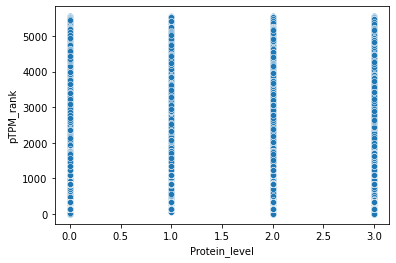

In [111]:
sns.scatterplot(data=df, x='Protein_level', y='pTPM_rank')

In [116]:
def compute_correlations(x, y) -> tuple:

    pearson_r = stats.pearsonr(x, y)
    kendall_tau = stats.kendalltau(x, y)
    spearman_r = stats.spearmanr(x, y)

    print(f"""
        Pearson: {pearson_r}
        Kendall: {kendall_tau}
        Spearman: {spearman_r}
    """)

    return (pearson_r, kendall_tau, spearman_r)

compute_correlations(df['Protein_level'], df['pTPM_rank']);


        Pearson: (0.2390953915332532, 0.0)
        Kendall: KendalltauResult(correlation=0.19067849946024515, pvalue=0.0)
        Spearman: SpearmanrResult(correlation=0.24893672351007715, pvalue=0.0)
    


## Compute correlations on LRI genes

In [117]:
df_lri = pd.read_csv("LRI_human.tsv", sep='\t', error_bad_lines=False)
df_lri.head(3)

/home/eugen/miniconda3/envs/gnn/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 3385: expected 8 fields, saw 10\nSkipping line 3392: expected 8 fields, saw 10\nSkipping line 3397: expected 8 fields, saw 10\n'


,LRI,LIGAND_1,LIGAND_2,RECEPTOR_1,RECEPTOR_2,RECEPTOR_3,DATABASE,SOURCE
0,CRISP3:A1BG,CRISP3,NaN,A1BG,NaN,NaN,CellTalkDB,PMID:15461460
1,A2M:LRP1,A2M,NaN,LRP1,NaN,NaN,CellTalkDB;connectomeDB2020;NicheNet;SingleCel...,FANTOM5;HPMR;HPRD;PMID:10652313;PMID:12194978;...
2,AANAT:MTNR1A,AANAT,NaN,MTNR1A,NaN,NaN,CellTalkDB;connectomeDB2020;NicheNet;SingleCel...,FANTOM5;HPMR;PMID:12943195


In [120]:
ligands = (
    set(df_lri['LIGAND_1'])
    .union(set(df_lri['LIGAND_2']))
)
receptors = (
    set(df_lri['RECEPTOR_1'])
    .union(set(df_lri['RECEPTOR_2']))
    .union(set(df_lri['RECEPTOR_3']))
)

In [124]:
print("Correlations on ligands")

df_l = df.loc[df['Gene name'].isin(ligands)]
print(f"Shape of HPA from LRI ligands: {df_l.shape}")

df_l = add_gene_ranks(df_l)

compute_correlations(df_l['Protein_level'], df_l['pTPM_rank']);

Correlations on ligands
Shape of HPA from LRI ligands: (1808, 7)

        Pearson: (0.19122477079776634, 2.380836199053689e-16)
        Kendall: KendalltauResult(correlation=0.1615292760091207, pvalue=1.8312026185142895e-18)
        Spearman: SpearmanrResult(correlation=0.20535507141988285, pvalue=1.1452215549443404e-18)
    


In [125]:
print("Correlations on receptors")

df_r = df.loc[df['Gene name'].isin(receptors)]
print(f"Shape of HPA from LRI ligands: {df_r.shape}")

df_r = add_gene_ranks(df_r)

compute_correlations(df_r['Protein_level'], df_r['pTPM_rank']);

Correlations on receptors
Shape of HPA from LRI ligands: (2264, 7)

        Pearson: (0.28130797607408065, 1.902552180493847e-42)
        Kendall: KendalltauResult(correlation=0.21902757385359717, pvalue=2.143637900785664e-41)
        Spearman: SpearmanrResult(correlation=0.28322209633179696, pvalue=5.008499255512636e-43)
    
